# Lab 4 - Partial Least Squares Regression: Cosgrove et al.

### (0) Import necessary packages and load data
The data is based on a [paper by Cosgrove et al](http://pubs.rsc.org/en/content/articlepdf/2010/mb/b926287c).

In [1]:
# Import necessary libraries
% matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.io import loadmat
from sklearn.preprocessing import scale
from sklearn.cross_decomposition import PLSRegression

# Load data
data = loadmat('wk4_Cosgrove-data.mat', squeeze_me=True, struct_as_record=False)['s']

# Format data
X = data.X # the untransformed data matrix (66x102)
Y = data.Y # the untransformed LDH release at 48hours. (66x5)
phosphoproteins = data.phosphoproteins # names of phosphoproteins
conditions = data.conditions # cell array of the 66 conditions
drugList = data.drugList # description of the drugs used in each of the 66 conditions
drugListToxic = data.drugListToxic # binary value corresponding to whether drugList[i] is toxic
drugs = data.drugs # binary matrix mapping which measurements correspond to a drug treatment in drugList
cytokineList = data.cytokineList # cell array of cytokine treatments
ind4pProtein = data.ind4pProtein # the column indices corresponding to measurements of the 4 phosphoprotein subset

# Fix ind4pProtein so that it starts indexing at 0
ind4pProtein = ind4pProtein-1

### (1) Perform PLSR on the matrixes X and Y. Plot the percent variance explained. How many principle components do you need for each to explain 90% of the variance?

4 components are needed to explain 90% of the variance


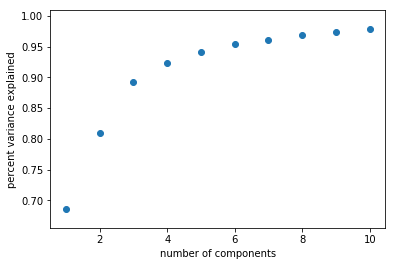

In [2]:
# Normalize X and Y
Y_obs = sp.stats.zscore(Y[:,4])
X_zscored = sp.stats.zscore(X)

# Find percent variance explained for an increasing number of principle components
percent_var = np.zeros(10)

for i in range(len(percent_var)):
    
    # Create instance of PLSR
    PLS = PLSRegression(n_components=i+1, max_iter=1000)
    
    # Fit the PLSRegression 
    xSc, ySc = PLS.fit_transform(X_zscored, Y_obs) # not the same as PLS.x_scores_
    
    # Find percent variance explained
    percent_var[i] = PLS.score(X_zscored, Y_obs)
    
    if (i > 0):
        if (percent_var[i] >= 0.9) & (percent_var[i-1] < 0.9):
            print(i+1, 'components are needed to explain 90% of the variance')

# Plot
plt.scatter(np.arange(1,len(percent_var)+1), percent_var)
plt.xlabel('number of components')
plt.ylabel('percent variance explained');

### (2) Recreate the Figure S2A plot from Cosgrove et al. supplementary information. This is the PLSR scores plot (for PC1 and PC2), with toxic drugs colored according to the drug type and all other drugs are not colored. Use the drugList, drugListToxic to identify these categories.
Figure S2A can be found [here](http://www.rsc.org/suppdata/mb/b9/b926287c/b926287c.pdf).

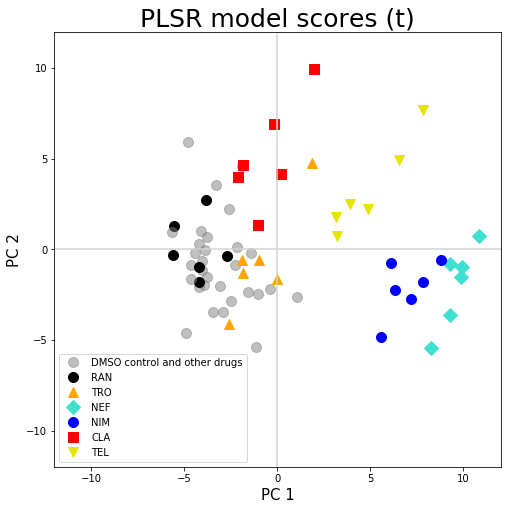

In [3]:
# Iterate and plot by color and shape
colors = ['k', 'orange', '#40e0d0', 'b', 'r', '#e5e500']
c_indx = -1
shapes = ['o', 'o', '^', 'D', 'o', 's', 'v']
shape_indx = 0

# Set up plot
plt.figure(figsize=(8,8))
plt.xlim(-12,12)
plt.ylim(-12,12)
plt.title('PLSR model scores (t)', fontsize=25)
plt.xlabel('PC 1', fontsize=15)
plt.ylabel('PC 2', fontsize=15)

# for every drug
for indx in np.arange(drugs.shape[1]):
    # if drug not toxic, color gray and shape circle
    if drugListToxic[indx]==0:
        color = 'gray'
        shape = shapes[0]
        alph = 0.5
    # else, special color and shape
    else:
        c_indx+=1
        color = colors[c_indx]
        shape_indx+=1
        shape = shapes[shape_indx]
        alph = 1
    # plot the scores
    mask = drugs[:,indx]==1
    xVals = xSc[:,0]
    yVals = xSc[:,1]
    drugX = xVals[mask]
    drugY = yVals[mask]
    if drugListToxic[indx]==0 and indx!=0:
        plt.plot(drugX, drugY, shape, markersize=10, c=color, alpha = alph, label='_nolegend_')
    else:
        plt.plot(drugX, drugY, shape, markersize=10, c=color, alpha = alph)

# plot legend
plt.legend(['DMSO control and other drugs', drugList[drugListToxic==1][0],
          drugList[drugListToxic==1][1], drugList[drugListToxic==1][2],
          drugList[drugListToxic==1][3], drugList[drugListToxic==1][4],
          drugList[drugListToxic==1][5]])

# plot axes
plt.axhline(0, color='#d3d3d3')
plt.axvline(0, color='#d3d3d3');

### (3) Create the loadings plot corresponding to (2). Interpret the results shown on the plot.

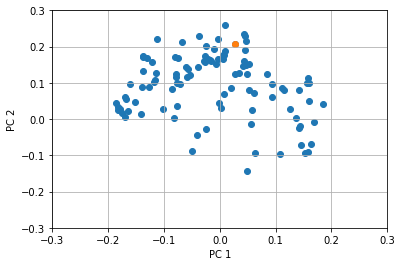

In [4]:
# Load loadings
loadings = PLS.x_loadings_

# Plot
plt.scatter(loadings[:,0], loadings[:,1])
plt.scatter(loadings[:,0][0], loadings[:,1][0])
plt.grid()
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.xlabel('PC 1')
plt.ylabel('PC 2');

The loading plot shows the direction of maximal covariance. The highlighted point is more heavily weighted on PC2 than PC1. Increasing this loading is predicted to increase LDH release.

### (4) Recreate a 4-principle component model using PLSR with just the final 4 phosphoprotein model. Plot predicted LDH versus observed LDH for this model. Report the model fitness (R^2). Define here how you are calculating R^2.

R2 = 0.89387271269


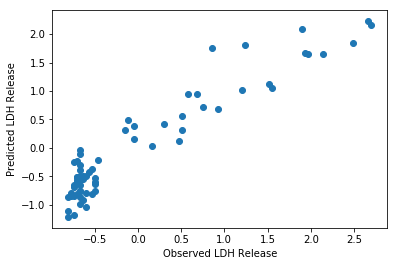

In [5]:
# New instance of PLSRegression
PLS2 = PLSRegression(n_components=4, max_iter=1000)

# Assign ind4pProtein
X_ind_zscored = sp.stats.zscore(X[:,ind4pProtein])

# Fit the PLSRegression 
xSc2, ySc2 = PLS2.fit_transform(X_ind_zscored, Y_obs)

# Find the predicted LDH
Y_model2 = np.squeeze(PLS2.predict(X_ind_zscored))

# Plot predicted against observed
plt.scatter(Y_obs, Y_model2)
plt.xlabel('Observed LDH Release')
plt.ylabel('Predicted LDH Release')

# Calculate R2
R2 = 1 - np.sum((Y_model2-Y_obs)**2)/np.sum(Y_obs**2)
print('R2 =', R2)

### (5) Cosgrove et al. Discusses their method for model validation using leave- one-out cross-validation. Calculate all LDH predictions for leave-one-out cross-validation and calculate the R^2 value for the resulting yfit values. What is the R^2 value?

R2 = 0.847813385574


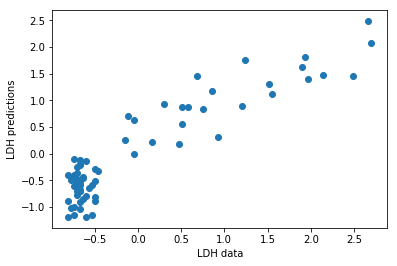

In [6]:
# Import library to split into train/test data for LOOCV
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

# z-score X and Y
X_zscored = sp.stats.zscore(X)
Y_obs = sp.stats.zscore(Y[:,4])
Y_model_CV = np.zeros(len(Y_obs))

# split into training and testing data
for train, test in loo.split(Y_obs):
    X_train = X_zscored[train]
    Y_train = Y_obs[train]
    
    # Build a model. Use PLSR
    
    # create new instance of PLSR
    PLS_CV = PLSRegression(n_components=4, max_iter=1000)
    
    # Fit X_train and Y_train
    PLS_CV.fit_transform(X_train, Y_train)
    
    # Find the predicted LDH
    Y_model_CV[test] = PLS_CV.predict(X_zscored[test])

# calculate R2
R2 = 1 - np.sum((Y_model_CV-Y_obs)**2)/np.sum(Y_obs**2)
print('R2 =', R2)

# Plot predicted against observed
plt.scatter(Y_obs, Y_model_CV)
plt.xlabel('LDH data')
plt.ylabel('LDH predictions');

### (6) Now, instead of performing LOOCV, let's perform leave-one-cytokine-out cross-validation. That is, one cytokine at a time, leave out all the data for the `NoCyt`, `IL-1`, `LPS`, `TNF`, `IL-6`, or `Mix` conditions.

How does this affect your cross-validation? How do the two approaches here differ? When might each be most appropriate?

R2 = 0.862427085093


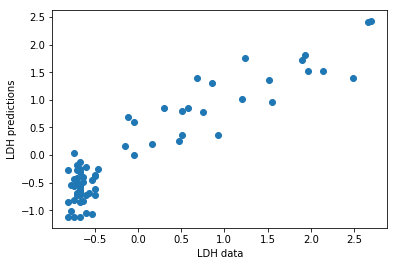

In [7]:
# Import library to split into train/test groups
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()
groups = np.tile(range(1,7), 11)
Y_model_LOGO = np.zeros(len(Y_obs))

# split into training and testing groups
for train, test in logo.split(X_zscored, Y_obs, groups):
    X_train = X_zscored[train]
    Y_train = Y_obs[train]
    
    # Build a model. Use PLSR
    
    # Create new instance of PLSRegression
    PLS_LOGO = PLSRegression(n_components=4, max_iter=1000)
    
    # Fit X_train and Y_train
    PLS_LOGO.fit_transform(X_train, Y_train)
    
    # Find the predicted LDH
    Y_model_LOGO[test] = np.squeeze(PLS_LOGO.predict(X_zscored[test]))

# Calculate R2
R2 = 1 - np.sum((Y_model_LOGO-Y_obs)**2)/np.sum(Y_obs**2)
print('R2 =',R2)

# Plot predicted against observed
plt.scatter(Y_obs, Y_model_LOGO)
plt.xlabel('LDH data')
plt.ylabel('LDH predictions');

Whether leave-one-out cross-validation (LOOCV) or leave-one-group-out cross-validation (LOGOCV) is used has only a very small effect on the prediction error. While LOOCV leaves out one condition, it still includes information on the rest of the cytokine family. Therefore, LOOCV can be used to predict how the test cytokine will behave if its behavior with other drugs are known. On the other hand, LOGOCV leaves out the entire cytokine family during the training process. Therefore, LOGOCV can be used to predict the behavior of cytokines without previous data.